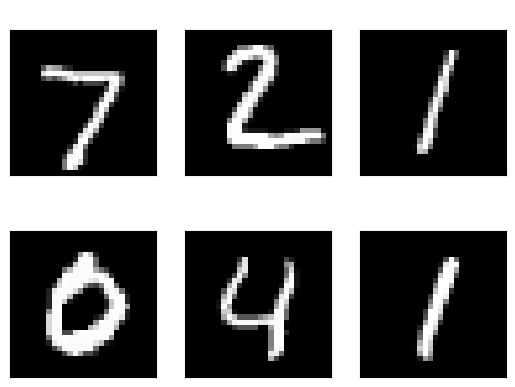

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import gc

torch.manual_seed(1)

# Load and prepare MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=600, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Plot a sample of test data
test_iter = iter(test_loader)
example_data, example_targets = next(test_iter)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("Actual Val: {}".format(example_targets[i]),color='white')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
def trainFunc(model,num_epochs):
    model.train()
    n_total_steps = len(train_loader)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    trainAvgLossArr = []
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum = 0

        for i, (images, labels) in enumerate(train_loader):  
            # Forward pass
            prediction = model(images)
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end='\r',flush=True)
                train_epoch.append(epoch)
                train_losses.append(loss.item())
                print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %',end='\r',flush=True)
                train_acc.append(acc)

                if epoch == num_epochs:
                        print(f"Max Epoch Reached, Loss: {loss.item():.4f}, Accuracy:{acc:2f}%")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False

        trainAvgLossArr.append(lossSum/i+1)
        
                        
    return train_epoch,train_losses,train_acc,trainAvgLossArr

In [8]:
# Hyper-parameters 
input_size = 784 # 28x28
max_epochs = 15
learning_rate = 0.001
kernel_size = 4
weight_decay_val = 1e-4
dropout = 0.25
class CNN1(nn.Module):
    def __init__(self,):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(320, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN   
        x = self.dropout(x)   
        x = F.relu(self.fc2(x))        #Fully Connected NN           
        x = self.fc3(x)                #O/P Layer       
        return x

Total no of parameters in Model 1: 25550
Max Epoch Reached, Loss: 0.0921, Accuracy:98.201667%


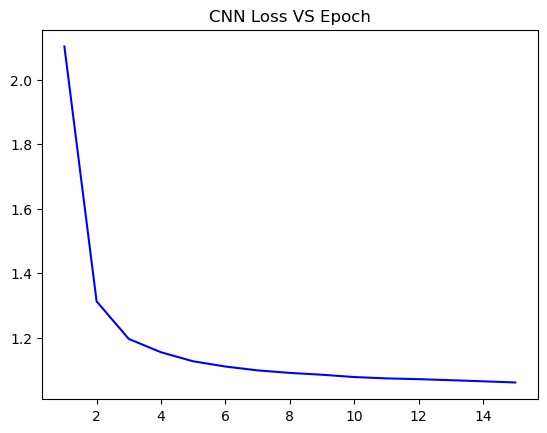

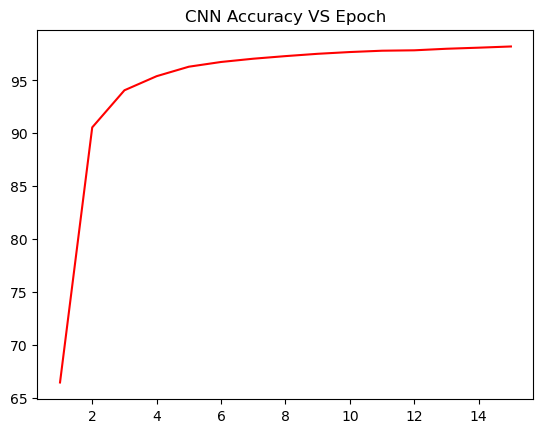

In [9]:
torch.manual_seed(1)

cnn1 = CNN1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]
for i in cnn1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)
train_epoch,train_losses,train_acc,trainAvgLossArr =trainFunc(cnn1,max_epochs)
plt.plot(train_epoch,trainAvgLossArr,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()
plt.plot(train_epoch,train_acc,color="red")
plt.title('CNN Accuracy VS Epoch')
plt.show()

In [17]:
def testFunc (model):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for test_images, test_labels in test_loader:
            outputs = model(test_images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += test_labels.size(0)
            n_correct += (predicted == test_labels).sum().item()
            
            for i in range(100):
                label = test_labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        netTest_acc1 = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {netTest_acc1} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {i}: {acc} %')
    
    return netTest_acc1
cnn1TestAcc = testFunc(cnn1)

Accuracy of the network: 98.73 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.03083700440529 %
Accuracy of 2: 99.12790697674419 %
Accuracy of 3: 99.00990099009901 %
Accuracy of 4: 98.26883910386965 %
Accuracy of 5: 98.54260089686099 %
Accuracy of 6: 99.26931106471817 %
Accuracy of 7: 97.95719844357977 %
Accuracy of 8: 98.870636550308 %
Accuracy of 9: 97.7205153617443 %


In [19]:
class CNN2(nn.Module):
    def __init__(self,):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(20*kernel_size*kernel_size, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,40)
        self.fc4 = nn.Linear(40,30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN       
        x = F.relu(self.fc2(x))        #Fully Connected NN 
        x = F.relu(self.fc3(x))        #Fully Connected NN 
        x = F.relu(self.fc4(x))        #Fully Connected NN
        #x = F.relu(self.fc5(x))        #Fully Connected NN 
        x = self.fc5(x)                #O/P Layer       
        return x
torch.manual_seed(1)

cnn2 = CNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn2.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 2:', np.sum(a),)
train_epoch2,train_losses2,train_acc2,trainAvgLossArr2=trainFunc(cnn2,max_epochs)

Total no of parameters in Model 2: 25570
Max Epoch Reached, Loss: 0.0857, Accuracy:97.845000%


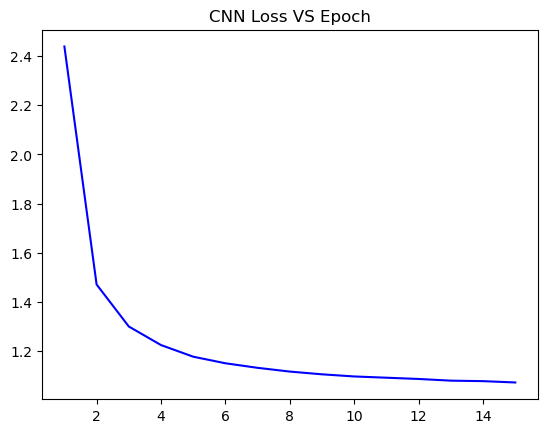

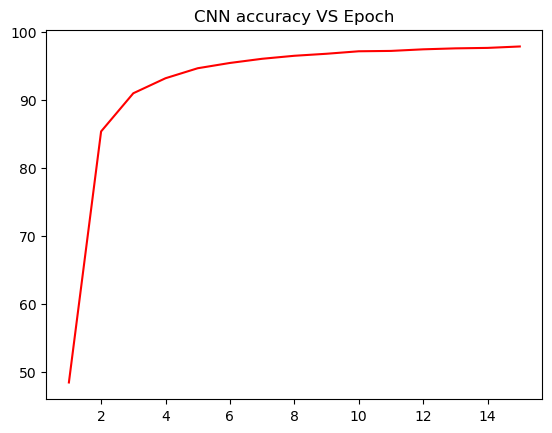

Accuracy of the network: 97.96 %
Accuracy of 0: 98.9795918367347 %
Accuracy of 1: 99.29515418502203 %
Accuracy of 2: 97.86821705426357 %
Accuracy of 3: 96.53465346534654 %
Accuracy of 4: 98.87983706720978 %
Accuracy of 5: 97.75784753363229 %
Accuracy of 6: 98.74739039665971 %
Accuracy of 7: 98.34630350194553 %
Accuracy of 8: 98.35728952772074 %
Accuracy of 9: 94.74727452923686 %


In [20]:
#plot
plt.plot(train_epoch2,trainAvgLossArr2,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()
#plot
plt.plot(train_epoch2,train_acc2,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()
cnn2TestAcc = testFunc(cnn2)

Total no of parameters in Model 3: 25621
Max Epoch Reached, Loss: 0.0230, Accuracy:98.885000%


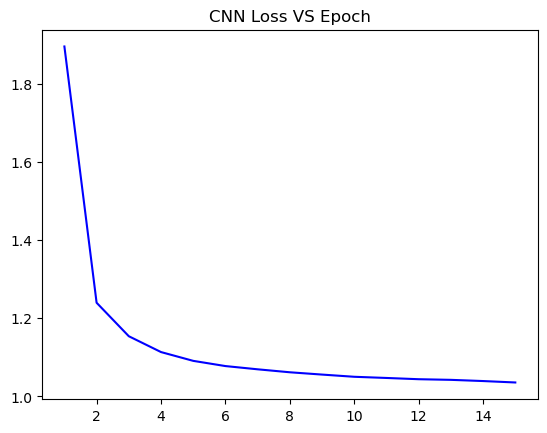

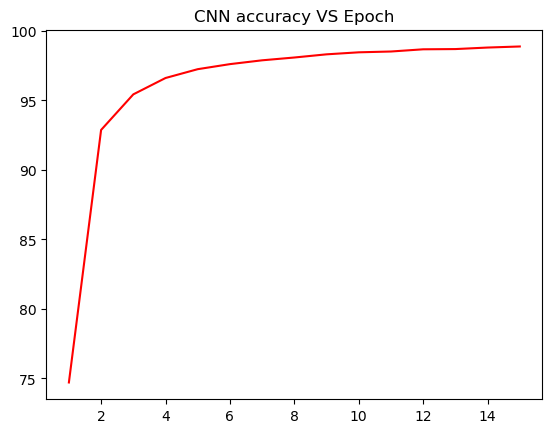

Accuracy of the network: 98.78 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.11894273127753 %
Accuracy of 2: 99.2248062015504 %
Accuracy of 3: 99.00990099009901 %
Accuracy of 4: 99.28716904276986 %
Accuracy of 5: 97.30941704035874 %
Accuracy of 6: 98.95615866388309 %
Accuracy of 7: 98.44357976653697 %
Accuracy of 8: 98.870636550308 %
Accuracy of 9: 97.9187314172448 %


In [21]:
#Model 3
class CNN3(nn.Module):
    def __init__(self,): 
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 15, 5)
        self.fc1 = nn.Linear(15*4*4, 86)
        self.fc2 = nn.Linear(86, 10)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
     
        x = x.view(-1, 15*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
torch.manual_seed(1)

cnn3 = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn3.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(a))
train_epoch3,train_losses3,train_acc3,trainAvgLossArr3=trainFunc(cnn3,max_epochs)
#plot
plt.plot(train_epoch3,trainAvgLossArr3,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()
#plot
plt.plot(train_epoch3,train_acc3,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()
cnn3TestAcc = testFunc(cnn3)

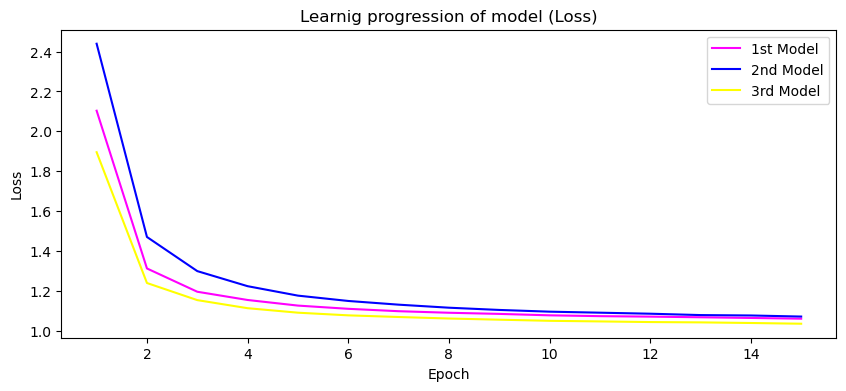

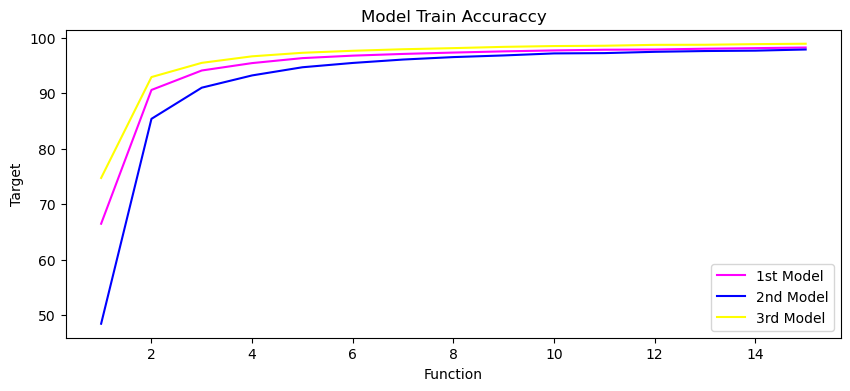

CNN1 Test Accuracy: 98.73 % 
CNN2 Test Accuracy: 97.96 % 
CNN3 Test Accuracy: 98.78 %


In [22]:
plt.figure(figsize=(10,4))
plt.plot(train_epoch,trainAvgLossArr, color = "magenta")
plt.plot(train_epoch2,trainAvgLossArr2, color = "blue")
plt.plot(train_epoch3,trainAvgLossArr3, color = "yellow")
plt.title('Learnig progression of model (Loss)')
plt.legend(['1st Model', '2nd Model','3rd Model','Orginal Value'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('EpochVSLossCNN.pdf')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_epoch,train_acc,color="magenta")
plt.plot(train_epoch2,train_acc2,color="blue")
plt.plot(train_epoch3,train_acc3,color="yellow")
plt.title('Model Train Accuraccy')
plt.legend(['1st Model', '2nd Model','3rd Model','Orginal Value'])
plt.xlabel('Function')
plt.ylabel('Target')
plt.savefig('Model_PredictionCNN.pdf')
plt.show()

print('CNN1 Test Accuracy:',cnn1TestAcc,'%','\nCNN2 Test Accuracy:',cnn2TestAcc,'%','\nCNN3 Test Accuracy:',cnn3TestAcc,'%')